# GTHA housing market database
# OSEMN methodology Step 2: Scrub
# Step 2.3 Spatial join of Teranet points with parcel-level land use

---

This notebook describes Step 2.3 (part of _Step 2: Scrub_ of OSEMN methodology) performed on the Teranet dataset.

Step 2.3 involves the spatial join of Teranet points with parcel-level land use.

Previous steps included: 

* Step 2.1 

    * the spatial join between the Teranet points and the polygons of GTHA Dissemination Areas (DAs)
    
    * During step 2.1, Teranet records whose coordinates fall outside of the GTHA boundary (as defined by the DA geometry) have been filtered out (6,803,691 of the original 9,039,241 Teranet records remain in the dataset)
     
    * In addition to that, three new columns (`OBJECTID`, `DAUID`, and `CSDNAME`) derived from DA attributes have been added to each Teranet transaction

---

For description of OSEMN methodology, see `methodology/0.osemn/osemn.pdf`.

For background information, description of the Teranet dataset, and its attributes, see `methodology/1.obtain/obtain.pdf`.

For description of _Step 2: Scrub_ of OSEMN methodology, see `methodology/2.scrub/scrub.pdf`.

For description of the cleanup plan for Teranet dataset, see `methodology/2.scrub/teranet_cleanup_plan.pdf`.

For description of Step 2.1 of the cleanup process, see `notebooks/2.scrub/2.1_teranet_gtha_spatial_join.ipynb`.


## Import dependencies

In [1]:
%matplotlib inline
import pandas as pd 
import geopandas as gpd
import os
from shapely.geometry import Point
from time import time

In [2]:
data_path = '../../data/'
teranet_path = data_path + 'teranet/'
os.listdir(teranet_path)

['3_Teranet_new_cols.csv',
 'epoi_gtha13',
 '2_Teranet_consistent.csv',
 '1.2_Teranet_DA_TAZ_cols.csv',
 '1.1_Teranet_DA_cols.csv',
 '1.3_Teranet_DA_TAZ_LU.csv',
 'ParcelLandUse.zip',
 'ParcelLandUse',
 'HHSaleHistory.csv',
 '3_Teranet_nonan_new_cols.csv',
 'GTAjoinedLanduseSales']

In [3]:
data_path = '../../data/'
gta_lu_path = data_path + 'teranet/ParcelLandUse/GTA/'
os.listdir(gta_lu_path)

['GTA_land_use_code.txt',
 'GTAparcel16LU12.shx',
 'with_epoi',
 'GTAparcel16LU12.prj',
 'GTAparcel16LU12.cpg',
 'GTAparcel16LU12.shp',
 'GTAparcel16LU12.dbf']

In [4]:
ham_lu_path = data_path + 'teranet/ParcelLandUse/Halmilton/'
os.listdir(ham_lu_path)

['Hparcel16LU10.prj',
 'Halmilton_Land_Use_Codes_2009_Original.pdf',
 'with_epoi',
 'HalLanduse_converted.csv',
 'Hparcel16LU10.cpg',
 'Hparcel16LU10.shp',
 'Hparcel16LU10.dbf',
 'Hparcel16LU10.shx']

## Load geometry of land use

----- GeoDataFrame loaded
in 123.62 seconds (2.06 minutes)
with 1,490,138 rows
and 13 columns
-- Column names:
 Index(['FID_1', 'PIN', 'SHAPE_Leng', 'SHAPE_Area', 'FID_2', 'OBJECTID',
       'PIN_1', 'municipali', 'LANDUSE', 'LengthM', 'AreaM2', 'Distance',
       'geometry'],
      dtype='object')
Taking the subset with columns
: ['PIN', 'LANDUSE', 'geometry']

-- New column names:
 Index(['PIN', 'LANDUSE', 'geometry'], dtype='object')


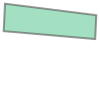

In [5]:
t = time()
lu_gta_gdf = gpd.read_file(gta_lu_path + 'GTAparcel16LU12.shp')
elapsed = time() - t

print("----- GeoDataFrame loaded"
      "\nin {0:.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(lu_gta_gdf.shape[0], lu_gta_gdf.shape[1]) + 
      "\n-- Column names:\n", lu_gta_gdf.columns)

cols = ['PIN', 'LANDUSE', 'geometry']

print("Taking the subset with columns\n:", cols)

lu_gta_gdf = lu_gta_gdf[cols]

print("\n-- New column names:\n", lu_gta_gdf.columns)
     
# lu_gta_gdf.plot(); # plotting the whole GeoDataFrame can take a very long time
lu_gta_gdf.iloc[0].geometry

----- GeoDataFrame loaded
in 13.97 seconds (0.23 minutes)
with 174,729 rows
and 13 columns
-- Column names:
 Index(['FID_1', 'PIN', 'SHAPE_Area', 'OBJECTID', 'FRONTAGE', 'DEPTH',
       'PROP_CODE', 'SITE_AREA', 'PIN_1', 'ID', 'Shape_Le_1', 'Shape_Ar_1',
       'geometry'],
      dtype='object')
Taking the subset with columns
: ['PIN', 'PROP_CODE', 'geometry']

-- New column names:
 Index(['PIN', 'PROP_CODE', 'geometry'], dtype='object')


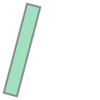

In [6]:
t = time()
lu_ham_gdf = gpd.read_file(ham_lu_path + 'Hparcel16LU10.shp')
elapsed = time() - t

print("----- GeoDataFrame loaded"
      "\nin {0:.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(lu_ham_gdf.shape[0], lu_ham_gdf.shape[1]) + 
      "\n-- Column names:\n", lu_ham_gdf.columns)

cols = ['PIN', 'PROP_CODE', 'geometry']

print("Taking the subset with columns\n:", cols)

lu_ham_gdf = lu_ham_gdf[cols]

print("\n-- New column names:\n", lu_ham_gdf.columns)
     
# lu_gta_gdf.plot(); # plotting the whole GeoDataFrame can take a very long time
lu_ham_gdf.iloc[0].geometry

## Load Teranet data

In [7]:
t = time()
teranet_df = pd.read_csv(teranet_path + '1.2_Teranet_DA_TAZ_cols.csv')
elapsed = time() - t
print("----- DataFrame loaded"
      "\nin {0:.2f} seconds".format(elapsed) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(teranet_df.shape[0], teranet_df.shape[1]) + 
      "\n-- Column names:\n", teranet_df.columns)

t = time()
# combine values in columns 'x' and 'y' into a POINT geometry object
geometry = [Point(xy) for xy in zip(teranet_df['X'], teranet_df['Y'])]
# generate a new GeoDataFrame by adding point geometry to data frame 'teranet_sales_data'
teranet_gdf = gpd.GeoDataFrame(teranet_df, geometry=geometry)
elapsed = time() - t
print("\n----- Geometry generated from 'X' and 'Y' pairs, GeoDataFrame created!"
      "\nin {0:.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(teranet_gdf.shape[0], teranet_gdf.shape[1]) + 
      "\n-- Column names:\n", teranet_gdf.columns)

# add CRS for WGS84 (lat-long) to GeoDataFrame with Teranet records
teranet_gdf.crs = {'proj': 'latlong', 
                   'ellps': 'WGS84', 
                   'datum': 'WGS84', 
                   'no_defs': True}
print("\n----- CRS dictionary for WGS84 added to geo data frame 'teranet_gdf'!")

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


----- DataFrame loaded
in 19.71 seconds
with 6,803,756 rows
and 19 columns
-- Column names:
 Index(['lro_num', 'pin', 'consideration_amt', 'registration_date',
       'POSTAL_CODE', 'PROVINCE', 'UNITNO', 'STREET_NAME',
       'STREET_DESIGNATION', 'STREET_DIRECTION', 'MUNICIPALITY',
       'STREET_SUFFIX', 'STREET_NUMBER', 'X', 'Y', 'DAUID', 'CSDUID',
       'CSDNAME', 'TAZ_O'],
      dtype='object')

----- Geometry generated from 'X' and 'Y' pairs, GeoDataFrame created!
in 95.75 seconds (1.60 minutes)
with 6,803,756 rows
and 20 columns
-- Column names:
 Index(['lro_num', 'pin', 'consideration_amt', 'registration_date',
       'POSTAL_CODE', 'PROVINCE', 'UNITNO', 'STREET_NAME',
       'STREET_DESIGNATION', 'STREET_DIRECTION', 'MUNICIPALITY',
       'STREET_SUFFIX', 'STREET_NUMBER', 'X', 'Y', 'DAUID', 'CSDUID',
       'CSDNAME', 'TAZ_O', 'geometry'],
      dtype='object')

----- CRS dictionary for WGS84 added to geo data frame 'teranet_gdf'!


## Perform the spatial join of Teranet points with DA polygons
### Validate projections

In [8]:
teranet_gdf.crs

{'proj': 'latlong', 'ellps': 'WGS84', 'datum': 'WGS84', 'no_defs': True}

In [9]:
lu_gta_gdf.crs

{'init': 'epsg:5320'}

In [10]:
lu_ham_gdf.crs

{'init': 'epsg:5320'}

### Convert Land Use CRS to EPSG:4326

In [11]:
t = time()
lu_gta_gdf = lu_gta_gdf.to_crs(epsg=4326)
elapsed = time() - t
print("New CRS:\n", lu_gta_gdf.crs, "\ntook {0:.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60))

New CRS:
 {'init': 'epsg:4326', 'no_defs': True} 
took 221.61 seconds (3.69 minutes)


In [12]:
t = time()
lu_ham_gdf = lu_ham_gdf.to_crs(epsg=4326)
elapsed = time() - t
print("New CRS:\n", lu_ham_gdf.crs, "\ntook {0:.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60))

New CRS:
 {'init': 'epsg:4326', 'no_defs': True} 
took 25.23 seconds (0.42 minutes)


### Perform the spatial join
>Note: EPSG:4326 and WGS 84 represent the [same projection](https://spatialreference.org/ref/epsg/wgs-84/).

In [13]:
t = time()
teranet_lu_gta_gdf = gpd.sjoin(teranet_gdf, lu_gta_gdf, 
                               how='left', op='within')
teranet_lu_gta_gdf = teranet_lu_gta_gdf.drop('index_right', axis=1)
elapsed = time() - t
print("\n----- Spatial join completed, new GeoDataFrame created"
      "\nin {0:.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(teranet_lu_gta_gdf.shape[0], teranet_lu_gta_gdf.shape[1]) + 
      "\n-- Column names:\n", teranet_lu_gta_gdf.columns)

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')



----- Spatial join completed, new GeoDataFrame created
in 1163.14 seconds (19.39 minutes)
with 6,803,767 rows
and 22 columns
-- Column names:
 Index(['lro_num', 'pin', 'consideration_amt', 'registration_date',
       'POSTAL_CODE', 'PROVINCE', 'UNITNO', 'STREET_NAME',
       'STREET_DESIGNATION', 'STREET_DIRECTION', 'MUNICIPALITY',
       'STREET_SUFFIX', 'STREET_NUMBER', 'X', 'Y', 'DAUID', 'CSDUID',
       'CSDNAME', 'TAZ_O', 'geometry', 'PIN', 'LANDUSE'],
      dtype='object')


In [14]:
t = time()
teranet_lu_gta_ham_gdf = gpd.sjoin(teranet_lu_gta_gdf, lu_ham_gdf, 
                                   how='left', op='within')
elapsed = time() - t
print("\n----- Spatial join completed, new GeoDataFrame created"
      "\nin {0:.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(teranet_lu_gta_ham_gdf.shape[0], teranet_lu_gta_ham_gdf.shape[1]) + 
      "\n-- Column names:\n", teranet_lu_gta_ham_gdf.columns)


----- Spatial join completed, new GeoDataFrame created
in 378.43 seconds (6.31 minutes)
with 6,803,767 rows
and 25 columns
-- Column names:
 Index(['lro_num', 'pin', 'consideration_amt', 'registration_date',
       'POSTAL_CODE', 'PROVINCE', 'UNITNO', 'STREET_NAME',
       'STREET_DESIGNATION', 'STREET_DIRECTION', 'MUNICIPALITY',
       'STREET_SUFFIX', 'STREET_NUMBER', 'X', 'Y', 'DAUID', 'CSDUID',
       'CSDNAME', 'TAZ_O', 'geometry', 'PIN_left', 'LANDUSE', 'index_right',
       'PIN_right', 'PROP_CODE'],
      dtype='object')


### Correct PINs
#### Overlap of values in `PIN_left` and `PIN_right`
Since the first spatial join affected Teranet records located in the GTA (GTA Land Use shapefile was being joined), and the second spatial join corresponded to Teranet records located in Hamilton (Hamilton Land Use shapefile was being joined), presence of values in resultant columns `PIN_left` and `PIN_right` overlaps (both `PIN_left` and `PIN_right` are not-null) only for 8 Teranet records, with actual PIN value being identical in both columns in each of these cases.

In [15]:
mask1 = teranet_lu_gta_ham_gdf['PIN_left'].isnull()
mask2 = teranet_lu_gta_ham_gdf['PIN_right'].isnull()
print("{0:,} records in the subset.".format(len(teranet_lu_gta_ham_gdf[~mask1 & ~mask2])))

8 records in the subset.


In [16]:
teranet_lu_gta_ham_gdf[~mask1 & ~mask2]

,lro_num,pin,consideration_amt,registration_date,POSTAL_CODE,PROVINCE,UNITNO,STREET_NAME,STREET_DESIGNATION,STREET_DIRECTION,...,DAUID,CSDUID,CSDNAME,TAZ_O,geometry,PIN_left,LANDUSE,index_right,PIN_right,PROP_CODE
307580,20,70930070,525000.0,8/21/1992 0:00:00,L7T1W4,ON,NaN,NORTH SHORE,BLVD,E,...,35240398,3524002,Burlington,2051.0,POINT (-79.83925694622141 43.30428802107259),070930070,99.0,6031.0,070930070,0.0
307772,20,70930070,1054000.0,11/30/2004 0:00:00,L7T1W4,ON,NaN,NORTH SHORE,BLVD,E,...,35240398,3524002,Burlington,2051.0,POINT (-79.83925694622141 43.30428802107259),070930070,99.0,6031.0,070930070,0.0
427036,20,71940013,1.0,5/1/1964 0:00:00,L7P0T2,ON,NaN,RENNICK,RD,NaN,...,35250948,3525005,Hamilton,2630.0,POINT (-79.87683365507159 43.3289585264729),071940013,1.0,507.0,071940013,0.0
427037,20,71940013,1.0,10/18/1965 0:00:00,L7P0T2,ON,NaN,RENNICK,RD,NaN,...,35250948,3525005,Hamilton,2630.0,POINT (-79.87683365507159 43.3289585264729),071940013,1.0,507.0,071940013,0.0
427043,20,71940013,0.0,6/5/2017 0:00:00,L7P0T2,ON,NaN,RENNICK,RD,NaN,...,35250948,3525005,Hamilton,2630.0,POINT (-79.87683365507159 43.3289585264729),071940013,1.0,507.0,071940013,0.0
2509726,20,71160056,25000.0,1/16/1987 0:00:00,L7T4G9,ON,NaN,LASALLE PARK,RD,NaN,...,35250496,3525005,Hamilton,2051.0,POINT (-79.8479414978225 43.3003977088099),071160056,99.0,6030.0,071160056,0.0
2509777,20,71160056,3450000.0,6/30/2016 0:00:00,L7T4G9,ON,NaN,LASALLE PARK,RD,NaN,...,35250496,3525005,Hamilton,2051.0,POINT (-79.8479414978225 43.3003977088099),071160056,99.0,6030.0,071160056,0.0
2509778,20,71160056,0.0,12/12/2006 0:00:00,L7T4G9,ON,NaN,LASALLE PARK,RD,NaN,...,35250496,3525005,Hamilton,2051.0,POINT (-79.8479414978225 43.3003977088099),071160056,99.0,6030.0,071160056,0.0


#### Collapse results of both joins into a single column 'pin_lu'
Since the values in both columns do not overlap, columns `PIN_left` and `PIN_right` can be collpased into a single column `pin_lu` without any loss of information. This is performed simply by reassigning values of `PIN_right` to records with missing `PIN_left`, and renaming `PIN_left` to `pin_lu`.

In [17]:
mask1 = teranet_lu_gta_ham_gdf['PIN_right'].isnull()
len(teranet_lu_gta_ham_gdf[mask1])

6321091

In [18]:
mask1 = teranet_lu_gta_ham_gdf['PIN_left'].isnull()
len(teranet_lu_gta_ham_gdf[mask1])

794631

In [19]:
mask1 = teranet_lu_gta_ham_gdf['PIN_left'].isnull()
old_nan = mask1.sum()
teranet_lu_gta_ham_gdf.loc[mask1, 'PIN_left'] = \
    teranet_lu_gta_ham_gdf.loc[mask1, 'PIN_right']
new_nan = teranet_lu_gta_ham_gdf['PIN_left'].isnull().sum()
print("{0:,} values of `PIN_left` (previously missing) have been filled using `PIN_right`."
      .format(old_nan - new_nan) +
      "\n{0:,} values of `PIN_left` remain missing.".format(new_nan))

482,668 values of `PIN_left` (previously missing) have been filled using `PIN_right`.
311,963 values of `PIN_left` remain missing.


In [20]:
teranet_lu_gta_ham_gdf = teranet_lu_gta_ham_gdf.rename(columns={'PIN_left':'pin_lu'})
print("Column `PIN_left` was renamed to `pin_lu`.")

Column `PIN_left` was renamed to `pin_lu`.


### Save results to a .csv file

In [21]:
teranet_lu_gta_ham_gdf.columns

Index(['lro_num', 'pin', 'consideration_amt', 'registration_date',
       'POSTAL_CODE', 'PROVINCE', 'UNITNO', 'STREET_NAME',
       'STREET_DESIGNATION', 'STREET_DIRECTION', 'MUNICIPALITY',
       'STREET_SUFFIX', 'STREET_NUMBER', 'X', 'Y', 'DAUID', 'CSDUID',
       'CSDNAME', 'TAZ_O', 'geometry', 'pin_lu', 'LANDUSE', 'index_right',
       'PIN_right', 'PROP_CODE'],
      dtype='object')

In [22]:
save_path = teranet_path + '1.3_Teranet_DA_TAZ_LU.csv'
t = time()
teranet_lu_gta_ham_gdf.drop(['index_right', 'geometry', 'PIN_right'], axis=1).to_csv(save_path, index=False)
elapsed = time() - t
print("DataFrame saved to file:\n", save_path,
      "\ntook {0:.2f} seconds".format(elapsed))

DataFrame saved to file:
 ../../data/teranet/1.3_Teranet_DA_TAZ_LU.csv 
took 150.65 seconds
